In [9]:
import numpy as np
import torch.nn as nn
import torch

In [2]:
rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

In [3]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

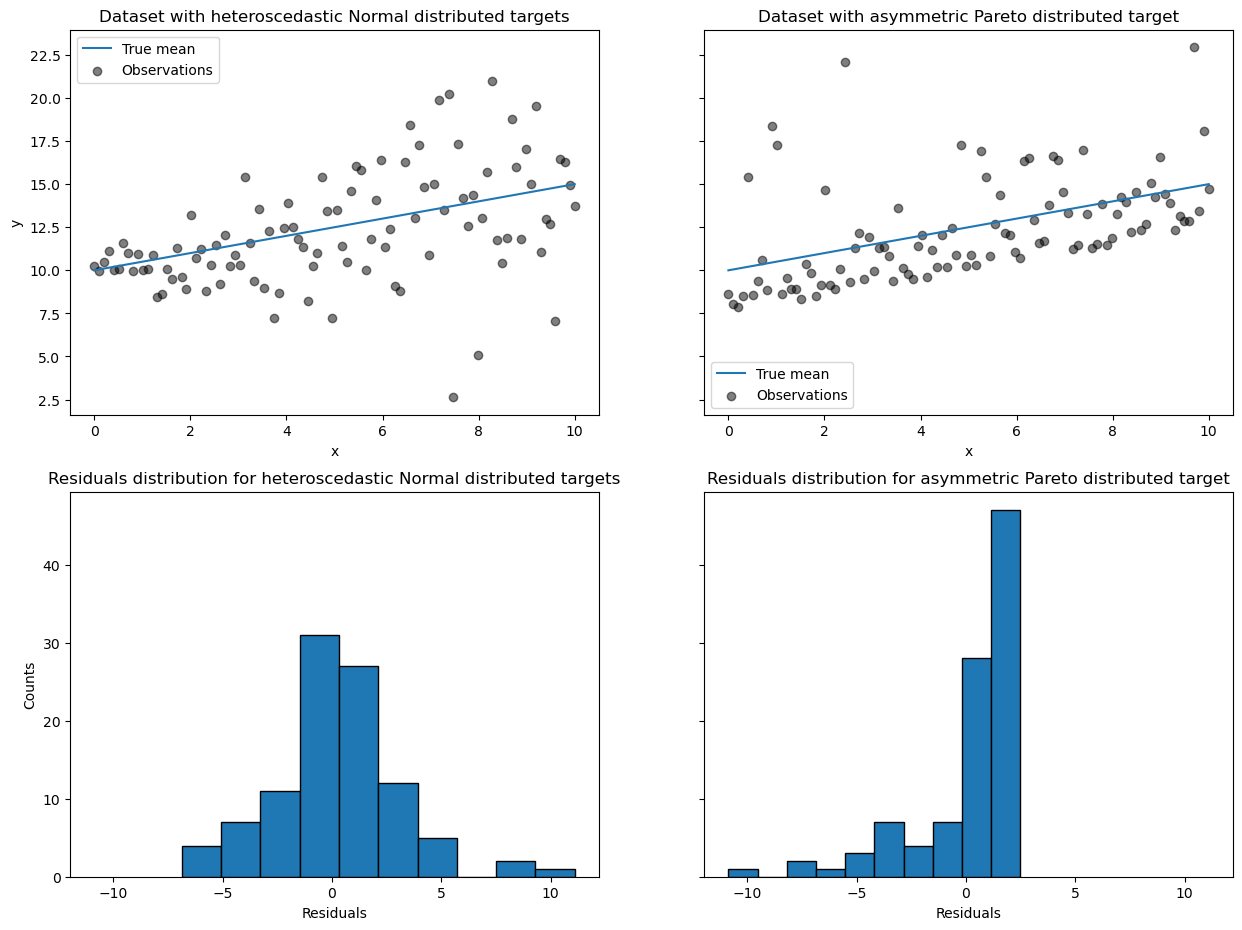

In [8]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

In [32]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e), dim=-1)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [61]:
X_train = torch.from_numpy(X)
y_train = torch.from_numpy(y_normal)

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]

input_size = 1
hidden_size = 64
output_size = 5

lr = 1e-2
num_epochs = 200

model = MLP(input_size, hidden_size, output_size).double()
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [62]:
# Training loop
for epoch in range(num_epochs):

    # Zero the parameter gradients
    opt.zero_grad()

    # Forward pass
    y_pred = model(X_train)

    # Calculate loss
    loss = 0.0
    for i, q in enumerate(quantiles):
        loss += tilted_loss(q, y_train, y_pred[:, i])

    # Backward pass and optimization
    loss.backward()
    opt.step()

    # Print statistics
    running_loss = loss.item()
    print('[%d] loss: %.3f' %
            (epoch + 1, running_loss))

print('Finished Training')

[1] loss: 29.014
[2] loss: 26.605
[3] loss: 24.201
[4] loss: 21.799
[5] loss: 19.419
[6] loss: 17.033
[7] loss: 14.793
[8] loss: 12.837
[9] loss: 11.264
[10] loss: 10.164
[11] loss: 9.417
[12] loss: 8.951
[13] loss: 8.661
[14] loss: 8.465
[15] loss: 8.291
[16] loss: 8.156
[17] loss: 8.040
[18] loss: 7.920
[19] loss: 7.816
[20] loss: 7.706
[21] loss: 7.582
[22] loss: 7.477
[23] loss: 7.375
[24] loss: 7.243
[25] loss: 7.092
[26] loss: 6.937
[27] loss: 6.773
[28] loss: 6.621
[29] loss: 6.498
[30] loss: 6.374
[31] loss: 6.236
[32] loss: 6.083
[33] loss: 5.911
[34] loss: 5.719
[35] loss: 5.509
[36] loss: 5.288
[37] loss: 5.065
[38] loss: 4.855
[39] loss: 4.667
[40] loss: 4.498
[41] loss: 4.345
[42] loss: 4.214
[43] loss: 4.090
[44] loss: 3.988
[45] loss: 3.903
[46] loss: 3.826
[47] loss: 3.760
[48] loss: 3.717
[49] loss: 3.694
[50] loss: 3.689
[51] loss: 3.685
[52] loss: 3.689
[53] loss: 3.691
[54] loss: 3.686
[55] loss: 3.673
[56] loss: 3.657
[57] loss: 3.635
[58] loss: 3.613
[59] loss: 3.

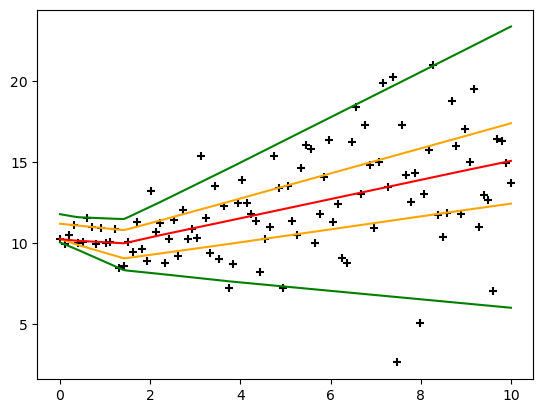

In [65]:
plt.scatter(X, y_normal, color='black', marker='+')
plt.plot(X, y_pred.detach().numpy()[:, 0], color='green')
plt.plot(X, y_pred.detach().numpy()[:, 1], color='orange')
plt.plot(X, y_pred.detach().numpy()[:, 2], color='red')
plt.plot(X, y_pred.detach().numpy()[:, 3], color='orange')
plt.plot(X, y_pred.detach().numpy()[:, 4], color='green')